In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
movies_df = pd.read_csv('tmdb_5000_movies.csv')

# Quick Overview
print(movies_df.info())
print(movies_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [3]:
# Clean Data
# Drop duplicate rows if any
movies_df = movies_df.drop_duplicates()

# Handle missing values
movies_df = movies_df.dropna(subset=['budget', 'revenue', 'genres', 'popularity'])

# Convert budget and revenue to numeric (ensure they're in numeric format)
movies_df['budget'] = pd.to_numeric(movies_df['budget'], errors='coerce')
movies_df['revenue'] = pd.to_numeric(movies_df['revenue'], errors='coerce')

# Fill or drop missing data in critical columns (e.g., runtime)
movies_df['runtime'] = movies_df['runtime'].fillna(movies_df['runtime'].median())

In [4]:
# Feature Engineering
# Create profit_margin
movies_df['profit_margin'] = (movies_df['revenue'] - movies_df['budget']) / movies_df['budget']

# Extract genres into a list
import ast
movies_df['genres_list'] = movies_df['genres'].apply(lambda x: [genre['name'] for genre in ast.literal_eval(x)] if pd.notnull(x) else [])

## Exploratory Data Analysis (EDA) 
##### 1. Relationship Between Genres, Popularity, and Revenue

                 popularity       revenue
genres_list                              
Adventure         39.268042  2.086602e+08
Animation         38.813439  2.256930e+08
Science Fiction   36.451806  1.524565e+08
Fantasy           36.387043  1.933542e+08
Action            30.940382  1.412131e+08
Family            27.832849  1.623455e+08
Mystery           24.586827  7.830093e+07
Thriller          24.460077  8.104429e+07
War               23.777289  8.415587e+07
Crime             22.853274  6.615066e+07
Horror            18.295915  4.354508e+07
Western           18.236279  4.624596e+07
Comedy            18.221001  7.128950e+07
Drama             17.764853  5.211623e+07
History           17.444839  5.752356e+07
Romance           15.962426  6.000239e+07
Music             13.101512  4.845595e+07
TV Movie           6.389415  0.000000e+00
Documentary        3.945724  9.838888e+06
Foreign            0.686787  3.646515e+05


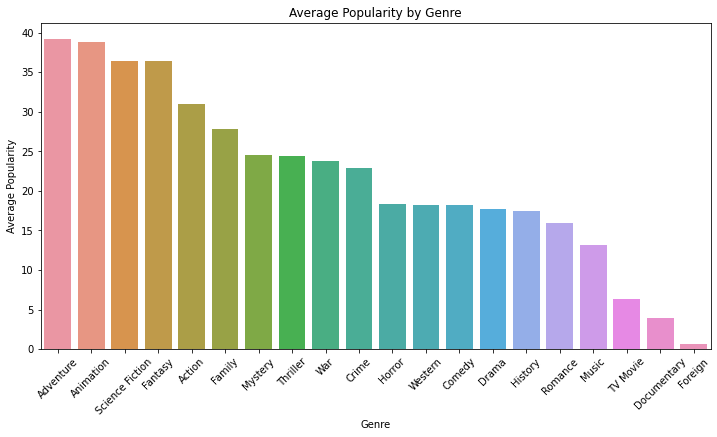

In [5]:
# Exploding genres for analysis
movies_exploded = movies_df.explode('genres_list')

# Average popularity and revenue by genre
genre_analysis = movies_exploded.groupby('genres_list')[['popularity', 'revenue']].mean().sort_values(by='popularity', ascending=False)
print(genre_analysis)

# Visualizing results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=genre_analysis.reset_index(), x='genres_list', y='popularity')
plt.title('Average Popularity by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Popularity')
plt.xticks(rotation=45)
plt.show()

##### 2. Influence of Release Year and Runtime on Popularity

              popularity       revenue
release_year                          
1916.0          3.232447  8.394751e+06
1925.0          0.785744  2.200000e+07
1927.0         32.351527  6.504220e+05
1929.0          1.396524  2.179000e+06
1930.0          8.484123  8.000000e+06
...                  ...           ...
2013.0         28.135912  1.013485e+08
2014.0         37.480126  1.013466e+08
2015.0         37.256857  1.054399e+08
2016.0         37.128692  1.390496e+08
2017.0          0.710870  0.000000e+00

[90 rows x 2 columns]


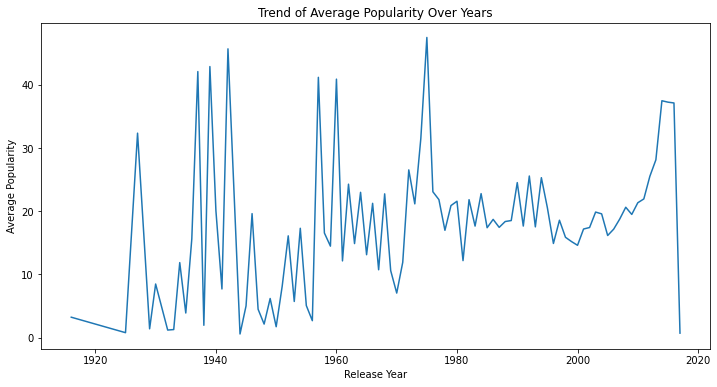

In [6]:
# Converting release_date to datetime and extracting year
movies_df['release_year'] = pd.to_datetime(movies_df['release_date'], errors='coerce').dt.year

# Average popularity and revenue by release year
year_analysis = movies_df.groupby('release_year')[['popularity', 'revenue']].mean()
print(year_analysis)

# Visualizing trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=year_analysis, x=year_analysis.index, y='popularity')
plt.title('Trend of Average Popularity Over Years')
plt.xlabel('Release Year')
plt.ylabel('Average Popularity')
plt.show()

### Clustering for Recommendation Design
Use clustering to group movies by similarity.

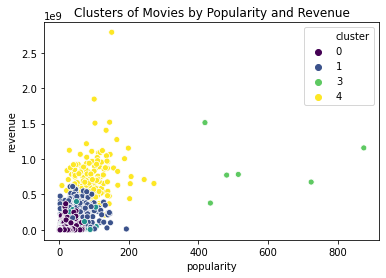

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select relevant features
features = movies_df[['popularity', 'revenue', 'budget', 'runtime']].fillna(0)

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
movies_df['cluster'] = kmeans.fit_predict(features_scaled)

# Visualize clusters
sns.scatterplot(data=movies_df, x='popularity', y='revenue', hue='cluster', palette='viridis')
plt.title('Clusters of Movies by Popularity and Revenue')
plt.show()


### Content-Based Recommendation
Use metadata (e.g., genres and popularity) for recommendations.

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Combine genres and keywords into a single string for vectorization
movies_df['metadata'] = movies_df['genres'] + " " + movies_df['tagline']

# Vectorize the metadata
vectorizer = CountVectorizer(stop_words='english')
metadata_matrix = vectorizer.fit_transform(movies_df['metadata'].fillna(''))

# Compute similarity matrix
similarity_matrix = cosine_similarity(metadata_matrix)

# Function to recommend movies based on similarity
def recommend_movies(movie_title, similarity_matrix, movies_df, top_n=5):
    # Find index of the given movie
    idx = movies_df[movies_df['title'] == movie_title].index[0]
    
    # Get similarity scores
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get top N recommendations
    top_movies = [movies_df.iloc[i[0]]['title'] for i in sim_scores[1:top_n+1]]
    return top_movies

# Example: Recommend movies similar to "Inception" and "Avatar"
print(recommend_movies("Inception", similarity_matrix, movies_df))
print(recommend_movies("Avatar", similarity_matrix, movies_df))

['Sky Captain and the World of Tomorrow', 'Paycheck', 'The Day After Tomorrow', 'Knowing', 'The Matrix Reloaded']
['Jupiter Ascending', 'The Wolverine', 'The Fifth Element', 'Man of Steel', 'John Carter']


### Regression Analysis
Predict popularity or revenue using features like budget and genres.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Select features and target
X = movies_df[['budget', 'runtime', 'release_year']].fillna(0)
y = movies_df['popularity']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Make predictions
y_pred = reg_model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 931.1958624415425
R^2 Score: 0.25


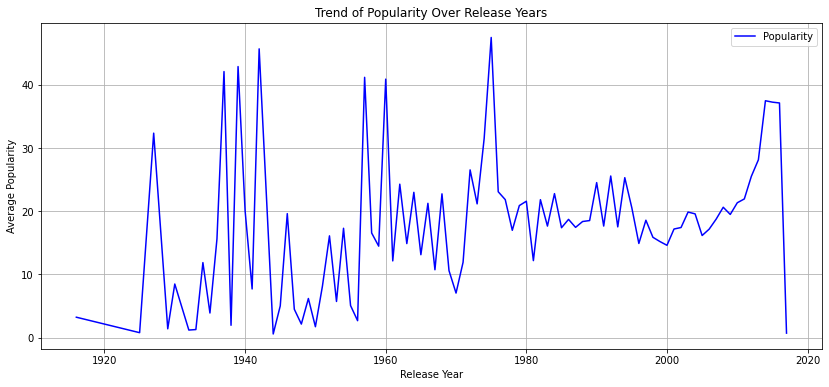

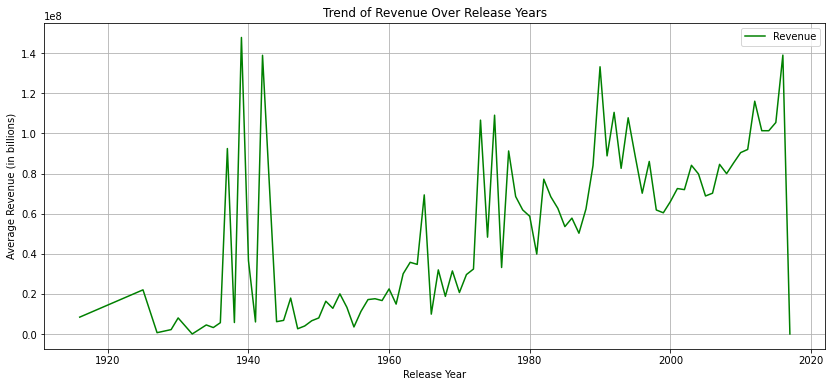

In [17]:
# Extract release year
movies_df['release_year'] = pd.to_datetime(movies_df['release_date'], errors='coerce').dt.year

# Group by release year and calculate average popularity and revenue
yearly_trends = movies_df.groupby('release_year')[['popularity', 'revenue']].mean()

# Drop years with missing values (e.g., NaN)
yearly_trends = yearly_trends.dropna()

# Visualization
plt.figure(figsize=(14, 6))

# Popularity Trend
sns.lineplot(data=yearly_trends, x=yearly_trends.index, y='popularity', label='Popularity', color='blue')
plt.title('Trend of Popularity Over Release Years')
plt.xlabel('Release Year')
plt.ylabel('Average Popularity')
plt.legend()
plt.grid(True)
plt.show()

# Revenue Trend
plt.figure(figsize=(14, 6))
sns.lineplot(data=yearly_trends, x=yearly_trends.index, y='revenue', label='Revenue', color='green')
plt.title('Trend of Revenue Over Release Years')
plt.xlabel('Release Year')
plt.ylabel('Average Revenue (in billions)')
plt.legend()
plt.grid(True)
plt.show()
